In [13]:
from nuscenes.nuscenes import NuScenes
import matplotlib.pyplot as plt
import cv2
import os
import matplotlib.patches as patches

In [14]:
data_path = '../../data'
nusc = NuScenes(version='v1.0-mini', dataroot=data_path, verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.839 seconds.
Reverse indexing ...
Done reverse indexing in 0.2 seconds.


In [15]:
from get_2D_boxes_from_sample_data import get_2D_boxes_from_sample_data
import json

In [16]:
# Função que recebe o token da cena e retorna as bounding boxes 2D com anotações
from nuscenes.utils.geometry_utils import BoxVisibility

def get_boxes_from_specified_frame(nusc, frame_token):
    
    sample = nusc.get('sample', frame_token) # Obter o sample específico pelo token de frame fornecido
    
    sample_data = nusc.get('sample_data', sample['data']['CAM_FRONT']) # Trocar para outros sensores aqui quando necessário
        
    # Chamar a função para obter as bounding boxes 2D
    boxes_anns = get_2D_boxes_from_sample_data(nusc, sample_data['token'], box_vis_level=BoxVisibility.ANY, visibilities=['1', '2', '3', '4'])
    
    return boxes_anns

In [17]:
# Plotar as bounding boxes e anotações
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def plot_boxes_on_image(image_path, boxes, annotations):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Criar uma figura e um eixo para plotar
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)
    
    # Plotar cada bounding box com sua anotação
    for box, label in zip(boxes, annotations):
        # Extrair coordenadas e dimensões da bounding box
        x_min, y_min, x_max, y_max = box
        width, height = x_max - x_min, y_max - y_min
        
        # Criar um retângulo para a bounding box
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='yellow', facecolor='none')
        ax.add_patch(rect)
        
        # Adicionar a etiqueta/label da bounding box
        ax.text(x_min, y_min, label, color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    
    plt.show()

In [18]:
# Inicializar o dicionário que armazenará os dados por cena
scenes_data = {}

for i in range(10): # Iterar sobre a qtd de cenas total
    scene = nusc.scene[i]
    scene_token = scene['token']  # Obter o token da cena atual
    frame_token = nusc.get('sample', scene['first_sample_token'])

    # Inicializar a lista que conterá os dados de todos os frames desta cena
    frames = []

    while frame_token['next'] != '':
        frame_token = nusc.get('sample', frame_token['next'])
        boxes, anns = get_boxes_from_specified_frame(nusc, frame_token['token'])
        image_path = data_path + '/' + nusc.get('sample_data', frame_token['data']['CAM_FRONT'])['filename']

        # Adicionar informações do frame na lista de frames
        frames.append({'boxes': boxes, 'anns': anns, 'path': image_path, 'token': nusc.get('sample_data', frame_token['data']['CAM_FRONT'])['token']})

    # Atribuir a lista de frames à cena correspondente no dicionário
    scenes_data[scene_token] = frames

# Agora, scenes_data contém um dicionário onde cada chave é um token de cena,
# e o valor é uma lista de dicionários com dados dos frames.

print(json.dumps(scenes_data, indent=4))

{
    "cc8c0bf57f984915a77078b10eb33198": [
        {
            "boxes": [
                [
                    1245.7866892853185,
                    475.34746781138864,
                    1267.3752896978735,
                    514.2613591929758
                ],
                [
                    1565.1104026754144,
                    488.6597179140922,
                    1694.2973419873183,
                    526.4010637661264
                ],
                [
                    1226.7018755315946,
                    475.59000645547866,
                    1273.3620227114468,
                    515.7308819823318
                ],
                [
                    1577.1906198398028,
                    477.48267535657646,
                    1619.9457222671745,
                    548.1815204433902
                ],
                [
                    778.0308304711076,
                    461.2120947464004,
                    795.0517880946078,
         

In [19]:
def convert_to_yolo_format(boxes, annotations, image_width, image_height, class_mapping):
    yolo_annotations = []
    bug = False

    for box, label in zip(boxes, annotations):
        x_min, y_min, x_max, y_max = box

        # Normalizar as coordenadas
        x_center = (x_min + x_max) / 2.0 / image_width
        y_center = (y_min + y_max) / 2.0 / image_height
        width = (x_max - x_min) / image_width
        height = (y_max - y_min) / image_height

        # Mapear a classe para um índice
        class_id = class_mapping[label]

        # Formato YOLO: <class_id> <x_center> <y_center> <width> <height>
        yolo_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")

        if x_center < 0 or x_center > 1 or y_center < 0 or y_center > 1 or width < 0 or width > 1 or height < 0 or height > 1:
            bug = True

    return yolo_annotations, bug

In [20]:
def getNuscClasses(): 
    category_names = {cat['token']: cat['name'] for cat in nusc.category}
    classes = {}
    i = 0
    for cat_token, cat_name in category_names.items():
        classes[cat_name] = i
        i += 1
    return classes

{'boxes': [(1245.7866892853185, 475.34746781138864, 1267.3752896978735, 514.2613591929758), (1565.1104026754144, 488.6597179140922, 1694.2973419873183, 526.4010637661264), (1226.7018755315946, 475.59000645547866, 1273.3620227114468, 515.7308819823318), (1577.1906198398028, 477.48267535657646, 1619.9457222671745, 548.1815204433902), (778.0308304711076, 461.2120947464004, 795.0517880946078, 497.89553257692756), (691.9907985307514, 467.2883776765617, 712.186120264203, 505.16438428579295), (1271.9772390067585, 502.4480693723625, 1357.3036887315434, 581.4717048033152), (1238.046740034082, 500.72142008555466, 1315.044754688693, 571.0993991738932), (1034.668746089555, 469.4960365224752, 1129.2981400764827, 543.1676918123081), (1253.2520159984251, 478.3723419481723, 1278.0726656381973, 518.1694237622283), (-578.2813013349307, -38.944528245006914, 570.6019589187357, 844.815195237285), (637.3313702985795, 451.0659965126783, 729.9389645284167, 491.64924277538495), (770.1870106750193, 457.04943177

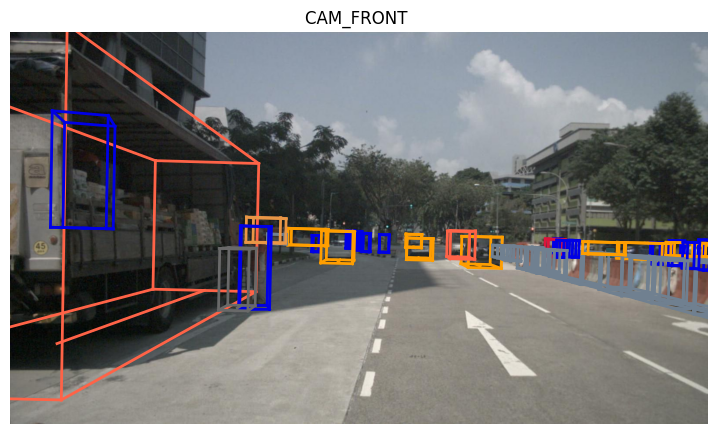

deu ruim


In [21]:
# Inserindo os dados YOLO formatados no dicionário de frames
class_mapping = getNuscClasses()
stop = False

for scene_token in scenes_data:
    frames = scenes_data[scene_token]  # Lista de frames para a cena atual
    for frame in frames:
        # Obter a largura e altura da imagem
        img = cv2.imread(frame['path'])
        img_height, img_width, _ = img.shape

        # Converter as boxes e anotações para o formato YOLO
        yolo_formatted_annotations, bug = convert_to_yolo_format(frame['boxes'], frame['anns'], img_width, img_height, class_mapping)

        # Adicionar as anotações YOLO formatadas ao dicionário do frame
        frame['yolo_anns'] = yolo_formatted_annotations

        if bug:
            print(frame)
            nusc.render_sample_data(frame['token'])
            stop = True
            break

        # Imprimir as anotações YOLO para verificar
        # print("\nYOLO formatted annotations for frame: ", frame['path'], "in scene: ", scene_token)
        # for annotation in yolo_formatted_annotations:
        #     print(annotation)
    
    if stop:
        print('deu ruim')
        break

In [22]:
# Função que recebe o token da cena e retorna as bounding boxes 2D com anotações
from nuscenes.utils.geometry_utils import BoxVisibility

def get_boxes_from_specified_frame(nusc, frame_token):
    
    sample = nusc.get('sample', frame_token) # Obter o sample específico pelo token de frame fornecido
    
    sample_data = nusc.get('sample_data', sample['data']['CAM_FRONT']) # Trocar para outros sensores aqui quando necessário
        
    # Chamar a função para obter as bounding boxes 2D
    boxes_anns = get_2D_boxes_from_sample_data(nusc, sample_data['token'], box_vis_level=BoxVisibility.ALL, visibilities=['1', '2', '3', '4'])
    
    return boxes_anns

In [23]:
# Inicializar o dicionário que armazenará os dados por cena
scenes_data = {}

for i in range(10): # Iterar sobre a qtd de cenas total
    scene = nusc.scene[i]
    scene_token = scene['token']  # Obter o token da cena atual
    frame_token = nusc.get('sample', scene['first_sample_token'])

    # Inicializar a lista que conterá os dados de todos os frames desta cena
    frames = []

    while frame_token['next'] != '':
        frame_token = nusc.get('sample', frame_token['next'])
        boxes, anns = get_boxes_from_specified_frame(nusc, frame_token['token'])
        image_path = data_path + '/' + nusc.get('sample_data', frame_token['data']['CAM_FRONT'])['filename']

        # Adicionar informações do frame na lista de frames
        frames.append({'boxes': boxes, 'anns': anns, 'path': image_path, 'token': nusc.get('sample_data', frame_token['data']['CAM_FRONT'])['token']})

    # Atribuir a lista de frames à cena correspondente no dicionário
    scenes_data[scene_token] = frames

# Agora, scenes_data contém um dicionário onde cada chave é um token de cena,
# e o valor é uma lista de dicionários com dados dos frames.

print(json.dumps(scenes_data, indent=4))

{
    "cc8c0bf57f984915a77078b10eb33198": [
        {
            "boxes": [
                [
                    1245.7866892853185,
                    475.34746781138864,
                    1267.3752896978735,
                    514.2613591929758
                ],
                [
                    1226.7018755315946,
                    475.59000645547866,
                    1273.3620227114468,
                    515.7308819823318
                ],
                [
                    778.0308304711076,
                    461.2120947464004,
                    795.0517880946078,
                    497.89553257692756
                ],
                [
                    691.9907985307514,
                    467.2883776765617,
                    712.186120264203,
                    505.16438428579295
                ],
                [
                    1271.9772390067585,
                    502.4480693723625,
                    1357.3036887315434,
           

In [24]:
# Inserindo os dados YOLO formatados no dicionário de frames
class_mapping = getNuscClasses()
stop = False

for scene_token in scenes_data:
    frames = scenes_data[scene_token]  # Lista de frames para a cena atual
    for frame in frames:
        # Obter a largura e altura da imagem
        img = cv2.imread(frame['path'])
        img_height, img_width, _ = img.shape

        # Converter as boxes e anotações para o formato YOLO
        yolo_formatted_annotations, bug = convert_to_yolo_format(frame['boxes'], frame['anns'], img_width, img_height, class_mapping)

        # Adicionar as anotações YOLO formatadas ao dicionário do frame
        frame['yolo_anns'] = yolo_formatted_annotations

        if bug:
            print(frame)
            nusc.render_sample_data(frame['token'])
            stop = True
            break

        # Imprimir as anotações YOLO para verificar
        # print("\nYOLO formatted annotations for frame: ", frame['path'], "in scene: ", scene_token)
        # for annotation in yolo_formatted_annotations:
        #     print(annotation)
    
    if stop:
        print('deu ruim')
        break